# 第14章 数据分析案例

本书正文的最后一章，我们来看一些真实世界的数据集。对于每个数据集，我们会用之前介绍的方法，从原始数据中提取有意义的内容。展示的方法适用于其它数据集，也包括你的。本章包含了一些各种各样的案例数据集，可以用来练习。

案例数据集可以在Github仓库找到，见第一章。

#14.1 来自Bitly的USA.gov数据

2011年，URL缩短服务Bitly跟美国政府网站USA.gov合作，提供了一份从生成.gov或.mil短链接的用户那里收集来的匿名数据。在2011年，除实时数据之外，还可以下载文本文件形式的每小时快照。写作此书时（2017年），这项服务已经关闭，但我们保存一份数据用于本书的案例。

以每小时快照为例，文件中各行的格式为JSON（即JavaScript Object Notation，这是一种常用的Web数据格式）。例如，如果我们只读取某个文件中的第一行，那么所看到的结果应该是下面这样：

In [32]:
import numpy as np
import pandas as pd

In [1]:
path = '../../datasets/bitly_usagov/example.txt'


open(path).readline()

'{ "a": "Mozilla\\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\\/535.11 (KHTML, like Gecko) Chrome\\/17.0.963.78 Safari\\/535.11", "c": "US", "nk": 1, "tz": "America\\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\\/\\/www.facebook.com\\/l\\/7AQEFzjSi\\/1.usa.gov\\/wfLQtf", "u": "http:\\/\\/www.ncbi.nlm.nih.gov\\/pubmed\\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }\n'

Python有内置或第三方模块可以将JSON字符串转换成Python字典对象。这里，我将使用json模块及其loads函数逐行加载已经下载好的数据文件：

In [5]:
import json


path = '../../datasets/bitly_usagov/example.txt'

records = [json.loads(line) for line in open(path)]

In [7]:

records[0:2]

[{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
  'c': 'US',
  'nk': 1,
  'tz': 'America/New_York',
  'gr': 'MA',
  'g': 'A6qOVH',
  'h': 'wfLQtf',
  'l': 'orofrog',
  'al': 'en-US,en;q=0.8',
  'hh': '1.usa.gov',
  'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
  'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991',
  't': 1331923247,
  'hc': 1331822918,
  'cy': 'Danvers',
  'll': [42.576698, -70.954903]},
 {'a': 'GoogleMaps/RochesterNY',
  'c': 'US',
  'nk': 0,
  'tz': 'America/Denver',
  'gr': 'UT',
  'g': 'mwszkS',
  'h': 'mwszkS',
  'l': 'bitly',
  'hh': 'j.mp',
  'r': 'http://www.AwareMap.com/',
  'u': 'http://www.monroecounty.gov/etc/911/rss.php',
  't': 1331923249,
  'hc': 1308262393,
  'cy': 'Provo',
  'll': [40.218102, -111.613297]}]

现在，records对象就成为一组Python字典了：

##用纯Python代码对时区进行计数

假设我们想要知道该数据集中最常出现的是哪个时区（即tz字段），得到答案的办法有很多。首先，我们用列表推导式取出一组时区：

In [8]:
time_zones = [rec['tz'] for rec in records]

KeyError: 'tz'

晕！原来并不是所有记录都有时区字段。这个好办，只需在列表推导式末尾加上一个if 'tz'in rec判断即可：

In [10]:
time_zones = [rec['tz'] for rec in records if 'tz' in rec]

time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

只看前10个时区，我们发现有些是未知的（即空的）。虽然可以将它们过滤掉，但现在暂时先留着。接下来，为了对时区进行计数，这里介绍两个办法：一个较难（只使用标准Python库），另一个较简单（使用pandas）。计数的办法之一是在遍历时区的过程中将计数值保存在字典中：

In [11]:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

如果使用Python标准库的更高级工具，那么你可能会将代码写得更简洁一些：

In [12]:
from collections import defaultdict


def get_counts2(sequence):
    counts = defaultdict(int) # values will initialize to 0
    for x in sequence:
        counts[x] += 1
    return counts

我将逻辑写到函数中是为了获得更高的复用性。要用它对时区进行处理，只需将time_zones传入即可：

In [13]:
counts = get_counts(time_zones)

counts['America/New_York']

1251

In [15]:
len(time_zones)

3440

如果想要得到前10位的时区及其计数值，我们需要用到一些有关字典的处理技巧：

In [16]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

然后有：

In [17]:
top_counts(counts)

[(33, 'America/Sao_Paulo'),
 (35, 'Europe/Madrid'),
 (36, 'Pacific/Honolulu'),
 (37, 'Asia/Tokyo'),
 (74, 'Europe/London'),
 (191, 'America/Denver'),
 (382, 'America/Los_Angeles'),
 (400, 'America/Chicago'),
 (521, ''),
 (1251, 'America/New_York')]

如果你搜索Python的标准库，你能找到collections.Counter类，它可以使这项工作更简单：

In [18]:
from collections import Counter

counts = Counter(time_zones)

counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

## 用pandas对时区进行计数

从原始记录的集合创建DateFrame，与将记录列表传递到pandas.DataFrame一样简单：

In [19]:
import pandas as pd


frame = pd.DataFrame(records)


frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a            3440 non-null   object 
 1   c            2919 non-null   object 
 2   nk           3440 non-null   float64
 3   tz           3440 non-null   object 
 4   gr           2919 non-null   object 
 5   g            3440 non-null   object 
 6   h            3440 non-null   object 
 7   l            3440 non-null   object 
 8   al           3094 non-null   object 
 9   hh           3440 non-null   object 
 10  r            3440 non-null   object 
 11  u            3440 non-null   object 
 12  t            3440 non-null   float64
 13  hc           3440 non-null   float64
 14  cy           2919 non-null   object 
 15  ll           2919 non-null   object 
 16  _heartbeat_  120 non-null    float64
 17  kw           93 non-null     object 
dtypes: float64(4), object(14)
memory usage: 500.8+ K

这里frame的输出形式是摘要视图（summary view），主要用于较大的DataFrame对象。我们然后可以对Series使用value_counts方法：

In [20]:
tz_counts = frame['tz'].value_counts()


tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

我们可以用matplotlib可视化这个数据。为此，我们先给记录中未知或缺失的时区填上一个替代值。fillna函数可以替换缺失值（NA），而未知值（空字符串）则可以通过布尔型数组索引加以替换：

In [21]:
clean_tz = frame['tz'].fillna('Missing')


clean_tz[clean_tz == ''] = 'Unknown'


tz_counts = clean_tz.value_counts()


tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

此时，我们可以用seaborn包创建水平柱状图（结果见图14-1）：

<Axes: >

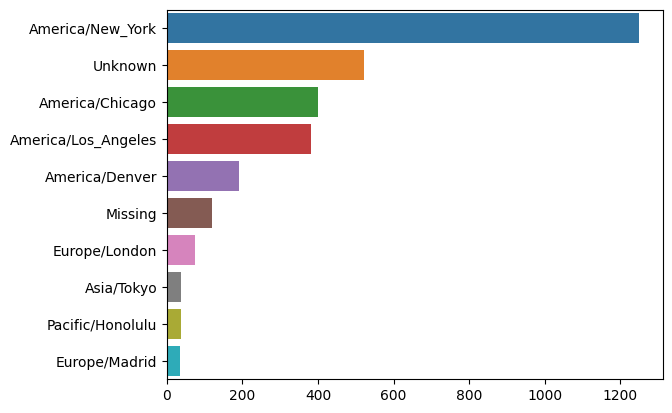

In [22]:
import seaborn as sns

subset = tz_counts[:10]

sns.barplot(y=subset.index, x=subset.values)

a字段含有执行URL短缩操作的浏览器、设备、应用程序的相关信息：

In [23]:
frame['a'][1]

'GoogleMaps/RochesterNY'

In [24]:
frame['a'][50]

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2'

In [25]:
frame['a'][51][:50]  # long line

'Mozilla/5.0 (Linux; U; Android 2.2.2; en-us; LG-P9'

将这些"agent"字符串中的所有信息都解析出来是一件挺郁闷的工作。一种策略是将这种字符串的第一节（与浏览器大致对应）分离出来并得到另外一份用户行为摘要：

In [26]:
results = pd.Series([x.split()[0] for x in frame.a.dropna()])


results[:5]

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [27]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

现在，假设你想按Windows和非Windows用户对时区统计信息进行分解。为了简单起见，我们假定只要agent字符串中含有"Windows"就认为该用户为Windows用户。由于有的agent缺失，所以首先将它们从数据中移除：

In [29]:
cframe = frame[frame.a.notnull()]

cframe

,a,c,nk,tz,gr,g,h,l,al,hh,r,u,t,hc,cy,ll,_heartbeat_,kw
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,1.0,America/New_York,MA,A6qOVH,wfLQtf,orofrog,"en-US,en;q=0.8",1.usa.gov,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,http://www.ncbi.nlm.nih.gov/pubmed/22415991,1.331923e+09,1.331823e+09,Danvers,"[42.576698, -70.954903]",NaN,NaN
1,GoogleMaps/RochesterNY,US,0.0,America/Denver,UT,mwszkS,mwszkS,bitly,NaN,j.mp,http://www.AwareMap.com/,http://www.monroecounty.gov/etc/911/rss.php,1.331923e+09,1.308262e+09,Provo,"[40.218102, -111.613297]",NaN,NaN
2,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,US,1.0,America/New_York,DC,xxr3Qb,xxr3Qb,bitly,en-US,1.usa.gov,http://t.co/03elZC4Q,http://boxer.senate.gov/en/press/releases/0316...,1.331923e+09,1.331920e+09,Washington,"[38.9007, -77.043098]",NaN,NaN
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,BR,0.0,America/Sao_Paulo,27,zCaLwp,zUtuOu,alelex88,pt-br,1.usa.gov,direct,http://apod.nasa.gov/apod/ap120312.html,1.331923e+09,1.331923e+09,Braz,"[-23.549999, -46.616699]",NaN,NaN
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,0.0,America/New_York,MA,9b6kNl,9b6kNl,bitly,"en-US,en;q=0.8",bit.ly,http://www.shrewsbury-ma.gov/selco/,http://www.shrewsbury-ma.gov/egov/gallery/1341...,1.331923e+09,1.273672e+09,Shrewsbury,"[42.286499, -71.714699]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,Mozilla/4.0 (compatible; MSIE 9.0; Windows NT ...,US,1.0,America/New_York,NJ,e5SvKE,fqPSr9,tweetdeckapi,en,1.usa.gov,direct,http://www.fda.gov/AdvisoryCommittees/Committe...,1.331927e+09,1.301298e+09,Paramus,"[40.9445, -74.07]",NaN,NaN
3556,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/535.1...,US,0.0,America/Chicago,OK,jQLtP4,jQLtP4,bitly,"en-US,en;q=0.8",1.usa.gov,http://www.facebook.com/l.php?u=http%3A%2F%2F1...,http://www.okc.gov/PublicNotificationSystem/Fo...,1.331927e+09,1.307530e+09,Oklahoma City,"[35.4715, -97.518997]",NaN,NaN
3557,GoogleMaps/RochesterNY,US,0.0,America/Denver,UT,mwszkS,mwszkS,bitly,NaN,j.mp,http://www.AwareMap.com/,http://www.monroecounty.gov/etc/911/rss.php,1.331927e+09,1.308262e+09,Provo,"[40.218102, -111.613297]",NaN,NaN
3558,GoogleProducer,US,0.0,America/Los_Angeles,CA,zjtI4X,zjtI4X,bitly,NaN,1.usa.gov,direct,http://www.ahrq.gov/qual/qitoolkit/,1.331927e+09,1.327529e+09,Mountain View,"[37.419201, -122.057404]",NaN,NaN


然后计算出各行是否含有Windows的值：

In [34]:
cframe['os'] = np.where(cframe['a'].str.contains('Windows'),
                        'Windows', 
                        'Not Windows'
                       )

cframe['os'][:5]

/tmp/ipykernel_140153/4132052293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cframe['os'] = np.where(cframe['a'].str.contains('Windows'),


0        Windows
1    Not Windows
2        Windows
3    Not Windows
4        Windows
Name: os, dtype: object

接下来就可以根据时区和新得到的操作系统列表对数据进行分组了：

In [35]:
by_tz_os = cframe.groupby(['tz', 'os'])

分组计数，类似于value_counts函数，可以用size来计算。并利用unstack对计数结果进行重塑：

In [36]:
agg_counts = by_tz_os.size().unstack().fillna(0)


agg_counts[:10]

os,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


最后，我们来选取最常出现的时区。为了达到这个目的，我根据agg_counts中的行数构造了一个间接索引数组：

In [37]:
indexer = agg_counts.sum(1).argsort()


indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

然后我通过take按照这个顺序截取了最后10行最大值：

In [38]:
count_subset = agg_counts.take(indexer[-10:])


count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


pandas有一个简便方法nlargest，可以做同样的工作：

In [39]:
agg_counts.sum(1).nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

然后，如这段代码所示，可以用柱状图表示。我传递一个额外参数到seaborn的barpolt函数，来画一个堆积条形图（见图14-2）：

In [40]:
# Rearrange the data for plotting
count_subset = count_subset.stack()


count_subset.name = 'total'


count_subset = count_subset.reset_index()


count_subset[:10]

,tz,os,total
0,America/Sao_Paulo,Not Windows,13.0
1,America/Sao_Paulo,Windows,20.0
2,Europe/Madrid,Not Windows,16.0
3,Europe/Madrid,Windows,19.0
4,Pacific/Honolulu,Not Windows,0.0
5,Pacific/Honolulu,Windows,36.0
6,Asia/Tokyo,Not Windows,2.0
7,Asia/Tokyo,Windows,35.0
8,Europe/London,Not Windows,43.0
9,Europe/London,Windows,31.0


<Axes: xlabel='total', ylabel='tz'>

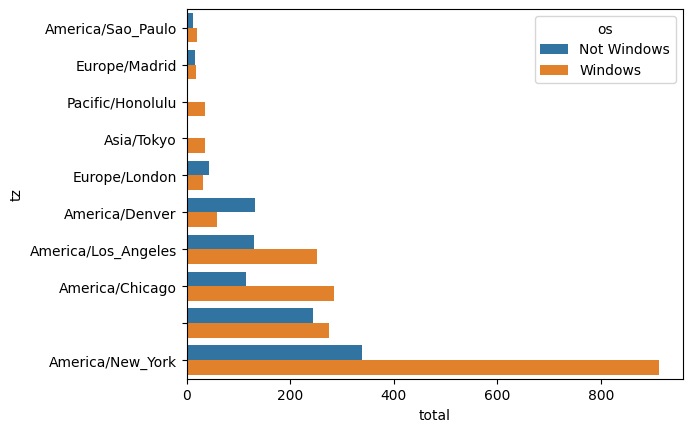

In [42]:
sns.barplot(x='total', 
            y='tz', 
            hue='os',  
            data=count_subset
           )


这张图不容易看出Windows用户在小分组中的相对比例，因此标准化分组百分比之和为1：

In [43]:
def norm_total(group):
    group['normed_total'] = group.total / group.total.sum()
    return group


results = count_subset.groupby('tz').apply(norm_total)

/tmp/ipykernel_140153/3421317349.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  results = count_subset.groupby('tz').apply(norm_total)


再次画图，见图14-3：

<Axes: xlabel='normed_total', ylabel='tz'>

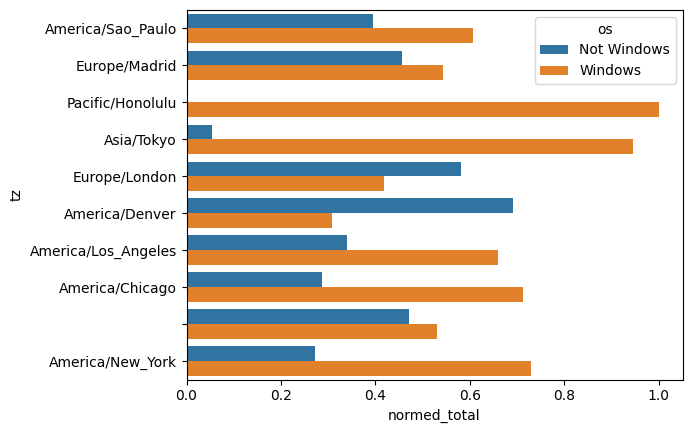

In [45]:
sns.barplot(x='normed_total', 
            y='tz', 
            hue='os',  
            data=results
           )

我们还可以用groupby的transform方法，更高效的计算标准化的和：

In [46]:
g = count_subset.groupby('tz')


results2 = count_subset.total / g.total.transform('sum')

In [49]:
results2

0     0.393939
1     0.606061
2     0.457143
3     0.542857
4     0.000000
5     1.000000
6     0.054054
7     0.945946
8     0.581081
9     0.418919
10    0.691099
11    0.308901
12    0.340314
13    0.659686
14    0.287500
15    0.712500
16    0.470250
17    0.529750
18    0.270983
19    0.729017
Name: total, dtype: float64

In [64]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

# plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

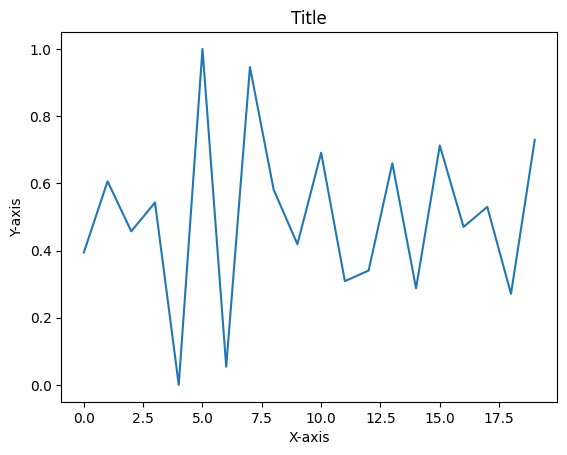

In [67]:
#Plot a linegraph
plt.plot(results2)

# Add labels and title 标准化的和
plt.title("Title")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [68]:
import matplotlib


print(matplotlib.matplotlib_fname())

/home/mylady/.virtualenvs/py-data-analysis/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc
